### Import library

In [1]:
!pip install simpletransformers --quiet

     |████████████████████████████████| 250 kB 2.1 MB/s 
     |████████████████████████████████| 9.2 MB 31.3 MB/s 
     |████████████████████████████████| 5.3 MB 63.7 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 7.6 MB 41.8 MB/s 
     |████████████████████████████████| 432 kB 52.0 MB/s 
     |████████████████████████████████| 1.3 MB 48.6 MB/s 
     |████████████████████████████████| 1.9 MB 40.7 MB/s 
     |████████████████████████████████| 163 kB 75.4 MB/s 
     |████████████████████████████████| 162 kB 61.2 MB/s 
     |████████████████████████████████| 182 kB 39.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 162 kB 74.2 MB/s 
     |████████████████████████████████| 158 kB 43.9 MB/s 
     |████████████████████████████████| 157 kB 47.8 MB/s 
     |████████████████████████████████| 157 kB 71.7 MB/s 
     |████████████████████████████████| 157 kB 68.6 MB/s 
     |█████████████

In [2]:
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,classification_report,confusion_matrix,matthews_corrcoef

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
###Dataset

In [3]:
!gdown --id 13N7TbjmljLhmxBHVSlXEVWyGB72-IEMh

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13N7TbjmljLhmxBHVSlXEVWyGB72-IEMh
To: /content/literature_comments_dataset.csv
100% 1.13M/1.13M [00:00<00:00, 72.5MB/s]


In [5]:
df=pd.read_csv(r'literature_comments_dataset.csv')
df=df[['Text Content', 'Code',]]
df=df.rename(columns={"Text Content": "Text"})
#class_names = ['Action on Issue', 'Bug Reproduction', 'Contribution and Commitment', 'Expected Behaviour', 'Investigation and Exploration', 'Motivation', 'Observed Bug Behaviour', 'Potential New Issues and Requests', 'Social Conversation', 'Solution Discussion', 'Task Progress', 'Usage', 'Workarounds']
print(df.shape)
df.head()

(4330, 2)


,Text,Code
0,Node.js (JavaScript) Wrapper API,Expected Behaviour
1,Because JavaScript is Awesome,Motivation
2,+1!,Social Conversation
3,+1,Social Conversation
4,:+1:,Social Conversation


### Cleaning

In [6]:
def heavy_text_clean(x):
    # first we lowercase everything
    x = x.lower()
    x = ' '.join([word for word in x.split(' ') if word not in stopwords])
    # remove unicode characters
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', 'URL ', x)
    x = re.sub(r'http*\S+', 'URL ', x)
    # then use regex to remove @ symbols and hashtags
    x = re.sub(r'(@[\w_-]+)', 'SCREEN_NAME', x)
    return x
df['Text'] = df.Text.apply(heavy_text_clean)

In [8]:
df = df.drop_duplicates(
  subset = ['Text', 'Code'],
  keep = 'first').reset_index(drop = True)

len(df)

4064

###Visualization

Solution Discussion                  1379
Social Conversation                   612
Investigation and Exploration         366
Usage                                 358
Motivation                            288
Bug Reproduction                      238
Potential New Issues and Requests     229
Observed Bug Behaviour                129
Expected Behaviour                    123
Task Progress                         123
Workarounds                            89
Contribution and Commitment            82
Action on Issue                        48
Name: Code, dtype: int64
4064


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


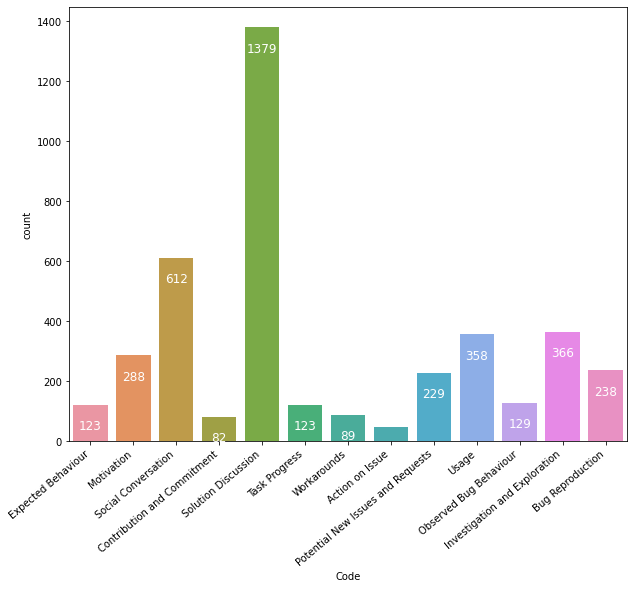

In [10]:
print(df['Code'].value_counts())
print(len(df))
plt.figure(figsize=(10,8))
ax=sns.countplot(df.Code)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)
plt.xlabel('Code');

In [ ]:
###Split into Train, Val, Test

In [12]:
type_label_map = {'Action on Issue':0, 'Bug Reproduction':1, 'Contribution and Commitment':2, 'Expected Behaviour':3, 'Investigation and Exploration':4, 'Motivation':5, 'Observed Bug Behaviour':6, 'Potential New Issues and Requests':7, 'Social Conversation':8, 'Solution Discussion':9, 'Task Progress':10, 'Usage':11, 'Workarounds':12}

df['Label'] = df.Code.replace(type_label_map)
codes=list(type_label_map.keys())
print(codes)

df_train, df_test = train_test_split(df, test_size=0.2,random_state=42)
df_val,df_test = train_test_split(df_test, test_size=0.5,random_state=6) 

print(len(df_train))
print(len(df_val))
print(len(df_test))

['Action on Issue', 'Bug Reproduction', 'Contribution and Commitment', 'Expected Behaviour', 'Investigation and Exploration', 'Motivation', 'Observed Bug Behaviour', 'Potential New Issues and Requests', 'Social Conversation', 'Solution Discussion', 'Task Progress', 'Usage', 'Workarounds']
3251
406
407


In [13]:
df_train['Label']= df_train['Label'].astype(int)
df_val['Label']= df_val['Label'].astype(int)
df_test['Label']= df_test['Label'].astype(int)

df_train['Text']= df_train['Text'].astype(str)
df_val['Text']= df_val['Text'].astype(str)
df_test['Text']= df_test['Text'].astype(str)

In [14]:
df_train=df_train.drop(columns=['Code'])
df_val=df_val.drop(columns=['Code'])
df_test=df_test.drop(columns=['Code'])
df_train.head()

,Text,Label
2525,"ah, thanks, missed that, example text processing.",8
3713,need use bothtensorflow andtsnein jupyter note...,5
3364,"16gb physical memory ssd, notice paging much.",9
436,anyone see performance benefits well?,9
3491,doubling length list insufficient.,4


### Train

In [15]:
model_type = "bert"
model_name = "bert-base-cased"

train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "use_cached_eval_features": True,
    "use_early_stopping": False,
    "early_stopping_delta": 0.0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize" : True,
    "early_stopping_patience" : 2,
    "evaluate_during_training": True,
    "output_dir": "output/"+model_type,
    "best_model_dir": "output/"+model_type+"/best_model",
    "max_seq_length": 512,
    "num_train_epochs": 10,
    "evaluate_during_training_steps": 64,
    "wandb_project": "Test",
    "wandb_kwargs": {"name": "Test"},
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "train_batch_size": 64,
    "eval_batch_size": 32,
    "learning_rate":2e-5,
    "evaluate_during_training_verbose" : True
}


In [ ]:

train_args["max_seq_length"] = 160 
train_args["train_batch_size"] = 64
train_args["gradient_accumulation_steps"] = 1
train_args["evaluate_during_training"] = True
train_args["evaluate_during_training_steps"] = 256
train_args["num_train_epochs"] = 5
train_args["use_early_stopping"] = True

# Create a ClassificationModel
model = ClassificationModel(model_type, model_name,num_labels=len(codes), args=train_args)
# Train the model
model.train_model(df_train,eval_df=df_val)

### Validation

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_val)
print(result)